In [1]:
import sys
sys.path.append('/Users/semvijverberg/surfdrive/Scripts/Extracting_precursor')

In [7]:
import func_mcK
import ROC_score

Whole
test year is [1982], with 2 events
test year is [1983], with 38 events
test year is [1984], with 15 events
test year is [1985], with 9 events
test year is [1986], with 7 events
test year is [1987], with 20 events
test year is [1988], with 61 events
test year is [1989], with 12 events
test year is [1990], with 13 events
test year is [1991], with 19 events
test year is [1992], with 2 events
test year is [1993], with 5 events
test year is [1994], with 7 events
test year is [1995], with 20 events
test year is [1996], with 4 events
test year is [1997], with 2 events
test year is [1998], with 0 events
test year is [1999], with 17 events
test year is [2000], with 14 events
test year is [2001], with 13 events
test year is [2002], with 22 events
test year is [2003], with 15 events
test year is [2004], with 3 events
test year is [2005], with 20 events
test year is [2006], with 21 events
test year is [2007], with 26 events
test year is [2008], with 7 events
test year is [2009], with 1 event

KeyError: 'leave_n_out'

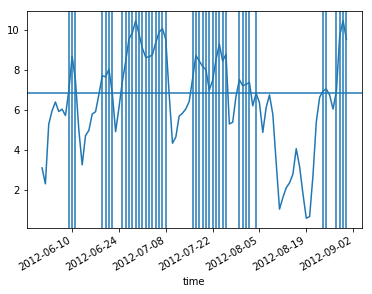

In [9]:
# %load extracting_features_rand_traintest.py
#!/usr/bin/env python3
"""
Created on Tue Nov 13 14:40:40 2018

@author: semvijverberg
"""

import os, sys
os.chdir('/Users/semvijverberg/surfdrive/Scripts/Extracting_precursor/')
script_dir = os.getcwd()
if sys.version[:1] == '3':
    from importlib import reload as rel
import func_mcK
from ROC_score import ROC_score
import numpy as np
import xarray as xr 
import pandas as pd
import cartopy.crs as ccrs
xrplot = func_mcK.xarray_plot
import matplotlib.pyplot as plt
import scipy

base_path = "/Users/semvijverberg/surfdrive/Data_ERAint/"
exp_folder = ''
path_raw = os.path.join(base_path, 'input_raw')
path_pp  = os.path.join(base_path, 'input_pp')
if os.path.isdir(path_raw) == False : os.makedirs(path_raw) 
if os.path.isdir(path_pp) == False: os.makedirs(path_pp)
map_proj = ccrs.Miller(central_longitude=240)  


ex = dict(
     {'grid_res'     :       2.5,
     'startyear'    :       1982,
     'endyear'      :       2015,
     'base_path'    :       base_path,
     'path_raw'     :       path_raw,
     'path_pp'      :       path_pp,
     'sstartdate'   :       '1982-06-01',
     'senddate'     :       '1982-08-31',
     'map_proj'     :       map_proj,
     'figpathbase'     :       "/Users/semvijverberg/surfdrive/McKinRepl/T95_sst_NOAA"}
     )

if os.path.isdir(ex['figpathbase']) == False: os.makedirs(ex['figpathbase'])

#'Mckinnonplot', 'U.S.', 'U.S.cluster', 'PEPrectangle', 'Pacific', 'Whole', 'Southern'



region = 'Whole'
print(region)

# Load in mckinnon Time series
T95name = 'PEP-T95TimeSeries.txt'
mcKtsfull, datesmcK = func_mcK.read_T95(T95name, ex)
datesmcK_daily = func_mcK.make_datestr(datesmcK, ex)

# Selected Time series of T95 ex['sstartdate'] until ex['senddate']
mcKts = mcKtsfull.sel(time=datesmcK_daily)

# Load in external ncdf
ex['name'] = 'sst_NOAA'
#filename = '{}_1979-2017_2mar_31aug_dt-1days_2.5deg.nc'.format(ex['name'])
filename = '{}_1982-2017_2jan_31aug_dt-1days_2.5deg.nc'.format(ex['name'])
# full globe - full time series
varfullgl = func_mcK.import_array(filename, ex)

# filter out outliers of sst
if ex['name']=='sst':
    varfullgl.where(varfullgl.values < 3.5*varfullgl.std().values)



# take means over bins over tfreq days
ex['tfreq'] = 1
mcKts, datesmcK = func_mcK.time_mean_bins(mcKts, ex)
RV_ts = mcKts

def oneyr(datetime):
    return datetime.where(datetime.year==datetime.year[300]).dropna()

expanded_time = func_mcK.expand_times_for_lags(datesmcK, ex)
# Converting Mckinnon timestemp to match xarray timestemp
expandeddaysmcK = func_mcK.to_datesmcK(expanded_time, expanded_time[0].hour, varfullgl.time[0].dt.hour)
# region mckinnon - expanded time series
Prec_reg = func_mcK.find_region(varfullgl.sel(time=expandeddaysmcK), region=region)[0]
Prec_reg, datesvar = func_mcK.time_mean_bins(Prec_reg, ex)

matchdaysmcK = func_mcK.to_datesmcK(datesmcK, datesmcK[0].hour, Prec_reg.time[0].dt.hour)


# binary time serie when T95 exceeds 1 std
hotdaythreshold = mcKts.mean(dim='time').values + mcKts.std().values
Ev_dates = func_mcK.Ev_timeseries(mcKts, hotdaythreshold)

def plot_oneyr_events(xarray, threshold, test_year):
    testyear = xarray.where(xarray.time.dt.year == test_year).dropna(dim='time', how='any')
    freq = pd.Timedelta(testyear.time.values[1] - testyear.time.values[0])
    plotpaper = xarray.sel(time=pd.DatetimeIndex(start=testyear.time.values[0], 
                                                end=testyear.time.values[-1], 
                                                freq=freq ))
    #plotpaper = mcKtsfull.sel(time=pd.DatetimeIndex(start='2012-06-23', end='2012-08-21', 
    #                                freq=(datesmcK[1] - datesmcK[0])))
    eventdays = plotpaper.where( plotpaper.values > threshold) 
    eventdays = eventdays.dropna(how='all', dim='time').time
    plt.figure()
    plotpaper.plot()
    plt.axhline(y=threshold)
    for days in eventdays.time.values:
        plt.axvline(x=days)
## plotting same figure as in paper
plot_oneyr_events(mcKts, hotdaythreshold, 2012)

# not merging hot days which happen consequtively
matchhotdates = func_mcK.to_datesmcK(Ev_dates, Ev_dates[0].dt.hour, varfullgl.time[0].dt.hour)



def plotting_wrapper(plotarr, filename, kwrgs=None):
#    if os.path.isdir(os.path.join(ex['fig_path'], foldername)) != True : 
#        os.makedirs(os.path.join(ex['fig_path'], foldername))
    file_name = os.path.join(ex['fig_path'], filename)
    if kwrgs == None:
        kwrgs = dict( {'vmin' : -3*plotarr.std().values, 'vmax' : 3*plotarr.std().values, 
                       'title' : title, 'clevels' : 'notdefault', 'steps':17,
                       'map_proj' : map_proj, 'cmap' : plt.cm.RdBu_r, 'column' : 2} )
    else:
        kwrgs = kwrgs
        kwrgs['title'] = plotarr.attrs['title']
    func_mcK.finalfigure(plotarr, file_name, kwrgs)
    
#%% Divide into train and validation step

def find_precursor(RV_ts, Prec_reg, ex):
    
    if leave_n_out == True:
        train, test, test_years = func_mcK.rand_traintest(RV_ts, Prec_reg, 
                                          ex)
        
        foldername = 'leave_{}_out_{}_{}_tf{}_{}'.format(ex['leave_n_years_out'],
                            ex['startyear'], ex['endyear'], ex['tfreq'],
                            ex['lags'])
        ex['exp_folder'] = os.path.join(ex['figpathbase'],foldername)
    elif leave_n_out == False:
        train = dict( { 'Prec'  : Prec_reg,
                        'RV'    : RV_ts,
                        'events': func_mcK.Ev_timeseries(RV_ts, ex['hotdaythres'])})
        test = train.copy()

        foldername = 'hindcast_{}_{}_tf{}_{}'.format(ex['startyear'],
                             ex['endyear'], ex['tfreq'], ex['lags'])
        ex['exp_folder'] = os.path.join(ex['figpathbase'],foldername)
        test_years = 'all_years'
    


# =============================================================================
#  Mean over 230 hot days
# =============================================================================

    ds_mcK = func_mcK.mcKmean(train, ex)  
    
# =============================================================================
# Extracting feature to build spatial map
# ============================================================================= 
   
    ds_Sem = func_mcK.extract_precursor(train, ex)    

# =============================================================================
# Force Leave_n_out validation even though pattern is based on whole dataset
# =============================================================================
    if leave_n_out == False and ROC_leave_n_out == True:
        train, test, test_years = func_mcK.rand_traintest(RV_ts, Prec_reg, 
                                          ex)
        
        foldername = 'Pattern_full_leave_{}_out_validation_{}_{}_tf{}_{}'.format(
                ex['leave_n_years_out'], ex['startyear'], ex['endyear'], 
                ex['tfreq'],ex['lags'])
    
        ex['exp_folder'] = os.path.join(ex['figpathbase'],foldername)
    
# =============================================================================
# calc ROC scores
# =============================================================================
    ROC_Sem  = np.zeros(len(ex['lags']))
    ROC_mcK  = np.zeros(len(ex['lags']))
    ROC_boot = np.zeros(len(ex['lags']))
    for lag in ex['lags']:
        idx = ex['lags'].index(lag)
        dates_test = func_mcK.to_datesmcK(test['RV'].time, test['RV'].time.dt.hour[0], 
                                           test['Prec'].time[0].dt.hour)
        # select antecedant SST pattern to summer days:
        dates_min_lag = dates_test - pd.Timedelta(int(lag), unit='d')
        var_test_mcK = func_mcK.find_region(test['Prec'], region='PEPrectangle')[0]
    #    full_timeserie_regmck = var_test_mcK.sel(time=dates_min_lag)

        var_test_mcK = var_test_mcK.sel(time=dates_min_lag)
        var_test_reg = test['Prec'].sel(time=dates_min_lag)        

        crosscorr_mcK = func_mcK.cross_correlation_patterns(var_test_mcK, 
                                                            ds_mcK['pattern'].sel(lag=lag))
        crosscorr_Sem = func_mcK.cross_correlation_patterns(var_test_reg, 
                                                            ds_Sem['pattern'].sel(lag=lag))
        
        
        if ex['method'] == 'iter':
            if ex['n'] == 0:
                ex['test_ts_mcK'][idx] = crosscorr_mcK.values 
                ex['test_ts_Sem'][idx] = crosscorr_Sem.values
                ex['test_RV'][idx]  = test['RV'].values
#                ex['test_RV_Sem'][idx]  = test['RV'].values
            else:
#                update_ROCS = ex['test_ts_mcK'][idx].append(list(crosscorr_mcK.values))
                ex['test_ts_mcK'][idx] = np.concatenate( [ex['test_ts_mcK'][idx], crosscorr_mcK.values] )
                ex['test_ts_Sem'][idx] = np.concatenate( [ex['test_ts_Sem'][idx], crosscorr_Sem.values] )
                ex['test_RV'][idx] = np.concatenate( [ex['test_RV'][idx], test['RV'].values] )
#                ex['test_RV_Sem'][idx] = np.concatenate( [ex['test_RV_Sem'][idx], var_test_reg.values] )
#            print(len(ex['test_ts_Sem']))
        
            if  ex['n'] == ex['n_conv']:
                n_boot = 5
                ROC_mcK[idx], ROC_boot = ROC_score(ex['test_ts_mcK'][idx], ex['test_RV'][idx],
                                      ex['hotdaythres'], lag, n_boot, 'default')
                ROC_Sem[idx] = ROC_score(ex['test_ts_Sem'][idx], ex['test_RV'][idx],
                                      ex['hotdaythres'], lag, 0, 'default')[0]
                print('\n*** ROC score for {} lag {} ***\n\nMck {:.2f} \t Sem {:.2f} '
                '\t ±{:.2f} 2*std random events\n\n'.format(region, 
                  lag, ROC_mcK[idx], ROC_Sem[idx], 2*np.std(ROC_boot)))
            
                
        elif ['method'] == 'random':        
                               
            # check detection of precursor:
            Prec_threshold_mcK = ds_mcK['perc'].sel(percentile=60 /10).values[0]
            Prec_threshold_Sem = ds_Sem['perc'].sel(percentile=60 /10).values[0]
            
            # =============================================================================
            # Determine events in time series
            # =============================================================================
            # check if there are any detections
            Prec_det_mcK = (func_mcK.Ev_timeseries(crosscorr_mcK, 
                                           Prec_threshold_mcK).size > ex['min_detection'])
            Prec_det_Sem = (func_mcK.Ev_timeseries(crosscorr_Sem, 
                                           Prec_threshold_Sem).size > ex['min_detection'])
            
    #        # plot the detections
    #        func_mcK.plot_events_validation(crosscorr_Sem, crosscorr_mcK, RV_ts_test, Prec_threshold_Sem, 
    #                                        Prec_threshold_mcK, ex['hotdaythres'], test_years[0])
    
    
            if Prec_det_mcK == True:
                n_boot = 1
                ROC_mcK[idx], ROC_boot = ROC_score(crosscorr_mcK, test['RV'],
                                      ex['hotdaythres'], lag, n_boot, ds_mcK['perc'])
    
    
            else:
                print('Not enough predictions detected, neglecting this predictions')
                ROC_mcK[idx] = ROC_boot = 0.5
    
    
            
            if Prec_det_Sem == True:
                n_boot = 0
                ROC_Sem[idx] = ROC_score(crosscorr_Sem, test['RV'],
                                      ex['hotdaythres'], lag, n_boot, ds_Sem['perc'])[0]
    #            ROC_std = 2 * np.std([ROC_boot_Sem, ROC_boot_mcK])
                
    #                Sem_ROCS.append(commun_comp.sel(lag=lag))
            else:
                print('Not enough predictions detected, neglecting this predictions')
                ROC_Sem = ROC_boot = 0.5
                                  
            
            print('\n*** ROC score for {} lag {} ***\n\nMck {:.2f} \t Sem {:.2f} '
                '\t ±{:.2f} 2*std random events\n\n'.format(region, 
                  lag, ROC_mcK[idx], ROC_Sem[idx], 2*np.std(ROC_boot)))
        
        # store output:
        ds_mcK['score'] = xr.DataArray(data=ROC_mcK, coords=[ex['lags']], 
                          dims=['lag'], name='score_diff_lags',
                          attrs={'units':'-'})
        ds_Sem['score'] = xr.DataArray(data=ROC_Sem, coords=[ex['lags']], 
                          dims=['lag'], name='score_diff_lags',
                          attrs={'units':'-'})

    
    score_per_run.append([test_years, len(test['events']), ds_mcK, ds_Sem, ROC_boot])
    
    
# ============================= ===============================================
#   # Saving figures in exp_folder
# =============================================================================
#    # ROC scores of this run
#    ROCsmcK = [round(mcK_ROCS[-(i+1)],2) for i in range(len(ex['lags']))][::-1]
#    ROCsSem = [round(Sem_ROCS[-(i+1)],2) for i in range(len(ex['lags']))][::-1]
#    exp_folder = '{}_{:.2f}_{:.2f}'.format(test_years, np.mean(ROCsmcK),
#                 np.mean(ROCsSem))
#    ex['fig_path'] = os.path.join(ex['exp_folder'], exp_folder)
#    if os.path.isdir(ex['fig_path']) == False: os.makedirs(ex['fig_path'])
#    # Plotting mcK
#    ds_mcK['pattern'].attrs['units'] = 'Kelvin (absolute values)'
#    title = 'PEP\ntest years : {}\n{}'.format(test_years, ROCsmcK)
#    ds_mcK['pattern'].attrs['title'] = title
#    plotting_wrapper(ds_mcK['pattern'], 'PEP') 
#    
#    # Plotting CPD
#    ds_Sem['pattern'].attrs['units'] = 'Weighted Kelvin (absolute values)'
#    file_name = 'CPD'
#    title = 'CPD\ntest years : {}\n{}'.format(test_years, ROCsSem)
#    ds_Sem['pattern'].attrs['title'] = title
#    plotting_wrapper(ds_Sem['pattern'], file_name) 
    
    

#                mcK_ROCS.append(ds_mcK['pattern'].sel(lag=lag))
        
    return score_per_run, ex
            
#%% Run until ROC has converged
    
leave_n_out = True ; ex['method'] = 'iter'

max_conv = len(set(RV_ts.time.dt.year.values))
ROC_leave_n_out = False



score_per_run = []

ex['lags'] = [0, 5, 10, 20, 30, 40]  
ex['min_detection'] = 5
ex['leave_n_years_out'] = 5
ex['hotdaythres'] = hotdaythreshold
ex['n_strongest'] = 15 
ex['n_std'] = 1.5   
ex['n_yrs'] = len(set(RV_ts.time.dt.year.values))
ex['n_conv'] = ex['n_yrs'] -1 
ex['toler'] = 0.010
if leave_n_out == True and ex['method'] == 'iter':
    ex['test_ts_mcK'] = np.zeros( len(ex['lags']) , dtype=list)
    ex['test_ts_Sem'] = np.zeros( len(ex['lags']) , dtype=list)
    ex['test_RV'] = np.zeros( len(ex['lags']) , dtype=list)
Convergence = False ; Conv_mcK = False ; Conv_Sem = False


ex['n'] = 0
while Convergence == False:
    n_lags = len(ex['lags'])
    # do single run
    score_per_run, ex = find_precursor(RV_ts, Prec_reg, ex)
    events_per_year = [score_per_run[i][1] for i in range(len(score_per_run))]
    l_ds_mcK       = [score_per_run[i][2] for i in range(len(score_per_run))]
    l_ds_Sem       = [score_per_run[i][3] for i in range(len(score_per_run))]
    ran_ROCS       = [score_per_run[i][4] for i in range(len(score_per_run))]
    
#    conv_std = [np.std(ran_ROCS[:n]) for n in range(len(ran_ROCS))]
#    plt.plot([np.std(ran_ROCS[:n]) for n in range(len(ran_ROCS))])
    def check_last_n_means(ds, n, ex):
        diff_last_n_means = np.zeros( (len(ex['lags'])) )
        ROC_at_lags = []
        means = []
        for lag in ex['lags']:
            idx = ex['lags'].index(lag)
            n_scores = len(ds)
            
            ROC_single_lag = []
            mean = []
            diff_means = []
            for n in range(n_scores):
                value = float(ds[n]['score'].sel(lag=lag).values)
                ROC_single_lag.append(value)
                mean.append(np.mean(ROC_single_lag))
            # calculating difference between last ex['n_conv'] mean values of runs
            diff_means.append([abs(mean[-n]-np.mean(mean[-ex['n_conv']:])) for n in range(ex['n_conv']-1)] )
            diff_means_mean = np.mean(diff_means)
            diff_last_n_means[idx] = diff_means_mean
            ROC_at_lags.append(ROC_single_lag)
            means.append( mean )
        return diff_last_n_means, ROC_at_lags, diff_means, means
    
    if ex['n'] >= ex['n_conv'] and ex['method'] == 'iter' and ex['leave_n_out'] == True:
        Convergence = True
    
    # Check convergence of ROC score mcKinnon
    if ex['n'] >= ex['n_conv'] and ex['method'] == 'random' and ex['leave_n_out'] == True:
        std_ran = np.std(ran_ROCS)
        diff_last_n_means, mean_at_lags, diff_means, means = check_last_n_means(l_ds_mcK, ex['n'], ex)
        scores_mcK = np.round(np.mean(mean_at_lags,axis=1),2)
        std_mcK    = np.round(np.std(mean_at_lags,axis=1),2)
        print('\nMean score of mcK {} ± {} 2*std'.format(scores_mcK,std_mcK))
        
        # calculating std between last ex['n_conv'] mean values of runs
        last_std = np.std(means, axis = 1)
        check1 = np.zeros( n_lags )
        check2 = np.zeros( n_lags )
        for l in range( n_lags):
            if last_std[l] < std_ran:
                check1[l] = True
            else:
                check1[l] = False
            if diff_last_n_means[l] < ex['toler']:
                check2[l] = True
            else:
                check2[l] = False
        check = np.append(check1, check2)
        all_True = np.ones( ( 2*len(ex['lags']) ),dtype=bool)
        if np.equal(check, all_True).all():
            Conv_mcK = True
            print('\nConvergence mcK is True')
    
    
    
    # Check convergence of ROC score Sem
    if ex['n'] >= ex['n_conv'] and ex['method'] == 'random' and ex['leave_n_out'] == True:
        std_ran = np.std(ran_ROCS)
        diff_last_n_means, mean_at_lags, diff_means, means = check_last_n_means(l_ds_Sem, ex['n'], ex)
        scores_Sem = np.round(np.mean(mean_at_lags,axis=1),2)
        std_Sem    = np.round(np.std(mean_at_lags,axis=1),2)
        print('\nMean score of Sem {} ± {} 2*std'.format(scores_Sem,std_Sem))

        # calculating std between last ex['n_conv'] mean values of runs
        last_std = np.std(means, axis = 1)
        check1 = np.zeros( n_lags )
        check2 = np.zeros( n_lags )
        for l in range( n_lags):
            if last_std[l] < std_ran:
                check1[l] = True
            else:
                check1[l] = False
            if diff_last_n_means[l] < ex['toler']:
                check2[l] = True
            else:
                check2[l] = False
        check = np.append(check1, check2)
        all_True = np.ones( ( 2*len(ex['lags']) ),dtype=bool)
        if np.equal(check, all_True).all():
            Conv_Sem = True
            print('\nConvergence Sem is True')
    
    if (Conv_mcK, Conv_Sem) == (True,True):
        Convergence = True
    
    if Convergence == True:
        print('\n**Converged after {} runs**\n\n\n'.format(ex['n']))
        text = ['\n**Converged after {} runs**\n\n\n']
    if ex['n'] == ex['n_conv']:
        Convergence = True
        print('Reached max_conv at {}'.format(ex['n']))
        
    ex['n'] += 1
    
        
#%%
events_per_year = [score_per_run[i][1] for i in range(len(score_per_run))]
score_mcK       = [score_per_run[i][2] for i in range(len(score_per_run))]
score_Sem       = [score_per_run[i][3] for i in range(len(score_per_run))]
plt.scatter(events_per_year, score_mcK)
plt.scatter(events_per_year, score_Sem)
#%%        

ds_mcK       = score_per_run[-1][2] 
ds_Sem       = score_per_run[-1][3] 

for lag in ex['lags']:
    idx = ex['lags'].index(lag)

    # select antecedant SST pattern to summer days:
    dates_min_lag = matchdaysmcK - pd.Timedelta(int(lag), unit='d')
    var_full_mcK = func_mcK.find_region(Prec_reg, region='PEPrectangle')[0]
    full_timeserie_regmck = var_full_mcK.sel(time=dates_min_lag)
    full_timeserie = Prec_reg.sel(time=dates_min_lag)
    
    # select test event predictand series
    RV_ts_test = mcKts
    crosscorr_mcK = func_mcK.cross_correlation_patterns(full_timeserie_regmck, 
                                                ds_mcK['pattern'].sel(lag=lag))
    crosscorr_Sem = func_mcK.cross_correlation_patterns(full_timeserie, 
                                                ds_Sem['pattern'].sel(lag=lag))
    n_boot = 5
    ROC_mcK, ROC_boot_mcK = ROC_score(crosscorr_mcK, RV_ts_test,
                                  ex['hotdaythres'], lag, n_boot, ds_mcK['perc'])
    ROC_Sem, ROC_boot_Sem = ROC_score(crosscorr_Sem, RV_ts_test,
                                  ex['hotdaythres'], lag, n_boot, ds_Sem['perc'])
    
#    ROC_mcK, ROC_boot_mcK = ROC_score(crosscorr_mcK, RV_ts_test,
#                                  ex['hotdaythres'], lag, n_boot, 'default')
#    ROC_Sem, ROC_boot_Sem = ROC_score(crosscorr_Sem, RV_ts_test,
#                                  ex['hotdaythres'], lag, n_boot, 'default')
    
    ROC_std = 2 * np.std([ROC_boot_mcK, ROC_boot_Sem])
    print('\n*** ROC score for {} lag {} ***\n\nMck {:.2f} \t Sem {:.2f} '
        '\t ±{:.2f} 2*std random events'.format(region, 
          lag, ROC_mcK, ROC_Sem, ROC_std))
#test_year = list(np.arange(2000, 2005))
#func_mcK.plot_events_validation(crosscorr_Sem, RV_ts_test, Prec_threshold, 
#                                ex['hotdaythres'], test_year)
      
#foldername = 'communities_Marlene'

#kwrgs = dict( {'vmin' : 0, 'vmax' : ex['n_strongest'], 
#                   'clevels' : 'notdefault', 'steps':ex['n_strongest']+1,
#                   'map_proj' : map_proj, 'cmap' : plt.cm.Dark2, 'column' : 2} )
#plotting_wrapper(commun_num, foldername, kwrgs=kwrgs)

  

